<a href="https://colab.research.google.com/github/kaledai069/Crossword-Solver-A-Neural-Transformer-based-Approach/blob/master/Update_Answer_Embedding_with_newly_added_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q wordsegment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.7 MB/s eta 0:00:00


In [39]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import re
import unicodedata
import string

from wordsegment import segment, load
from tqdm import tqdm
load()

In [4]:
MAIN_DATASET = "/content/gdrive/MyDrive/Clue-Answer Dataset/CLUE_ANSWER_DATA_VERSION_1.csv"
CHINESE_DATASET = "/content/gdrive/MyDrive/Clue-Answer Dataset/chinese_dataset.csv"
NEW_CSV_SET_DIR = "/content/gdrive/MyDrive/Clue-Answer Dataset/New Clue-Answer/"

In [5]:
def preprocess_clue_fn(clue):
    clue = str(clue)
    clue = clue.lower()
    clue = ''.join(c for c in unicodedata.normalize('NFD', clue) if unicodedata.category(c) != 'Mn')

    clue = re.sub("\x17|\x18|\x93|\x94|“|”|''|\"\"", "\"", clue)
    clue = re.sub("\x85|…", "...", clue)
    clue = re.sub("\x91|\x92|‘|’", "'", clue)

    clue = re.sub("‚", ",", clue)
    clue = re.sub("—|–", "-", clue)
    clue = re.sub("¢", " cents", clue)
    clue = re.sub("¿|¡|^;|\{|\}", "", clue)
    clue = re.sub("÷", "division", clue)
    clue = re.sub("°", " degrees", clue)

    euro = re.search("^£[0-9]+(,*[0-9]*){0,}| £[0-9]+(,*[0-9]*){0,}", clue)
    if euro:
        num = clue[:euro.end()]
        rest_clue = clue[euro.end():]
        clue = num + " Euros" + rest_clue
        clue = re.sub(", Euros", " Euros", clue)
        clue = re.sub("Euros [Mm]illion", "million Euros", clue)
        clue = re.sub("Euros [Bb]illion", "billion Euros", clue)
        clue = re.sub("Euros[Kk]", "K Euros", clue)
        clue = re.sub(" K Euros", "K Euros", clue)
        clue = re.sub("£", "", clue)

    clue = re.sub(" *\(\d{1,},*\)$| *\(\d{1,},* \d{1,}\)$", "", clue)

    clue = re.sub("&amp;", "&", clue)
    clue = re.sub("&lt;", "<", clue)
    clue = re.sub("&gt;", ">", clue)

    clue = re.sub("e\.g\.|for ex\.", "for example", clue)
    clue = re.sub(": [Aa]bbreviat\.|: [Aa]bbrev\.|: [Aa]bbrv\.|: [Aa]bbrv|: [Aa]bbr\.|: [Aa]bbr", " abbreviation", clue)
    clue = re.sub("abbr\.|abbrv\.", "abbreviation", clue)
    clue = re.sub("Abbr\.|Abbrv\.", "Abbreviation", clue)
    clue = re.sub("\(anag\.\)|\(anag\)", "(anagram)", clue)
    clue = re.sub("org\.", "organization", clue)
    clue = re.sub("Org\.", "Organization", clue)
    clue = re.sub("Grp\.|Gp\.", "Group", clue)
    clue = re.sub("grp\.|gp\.", "group", clue)
    clue = re.sub(": Sp\.", " (Spanish)", clue)
    clue = re.sub("\(Sp\.\)|Sp\.", "(Spanish)", clue)
    clue = re.sub("Ave\.", "Avenue", clue)
    clue = re.sub("Sch\.", "School", clue)
    clue = re.sub("sch\.", "school", clue)
    clue = re.sub("Agcy\.", "Agency", clue)
    clue = re.sub("agcy\.", "agency", clue)
    clue = re.sub("Co\.", "Company", clue)
    clue = re.sub("co\.", "company", clue)
    clue = re.sub("No\.", "Number", clue)
    clue = re.sub("no\.", "number", clue)
    clue = re.sub(": [Vv]ar\.", " variable", clue)
    clue = re.sub("Subj\.", "Subject", clue)
    clue = re.sub("subj\.", "subject", clue)
    clue = re.sub("Subjs\.", "Subjects", clue)
    clue = re.sub("subjs\.", "subjects", clue)

    theme_clue = re.search("^.+\|[A-Z]{1,}", clue)
    if theme_clue:
        clue = re.sub("\|", " | ", clue)

    if "Partner of" in clue:
        clue = re.sub("Partner of", "", clue)
        clue = clue + " and ___"

    link = re.search("^.+-.+ [Ll]ink$", clue)
    if link:
        no_link = re.search("^.+-.+ ", clue)
        x_y = clue[no_link.start():no_link.end() - 1]
        x_y_lst = x_y.split("-")
        clue = x_y_lst[0] + " ___ " + x_y_lst[1]

    follower = re.search("^.+ [Ff]ollower$", clue)
    if follower:
        no_follower = re.search("^.+ ", clue)
        x = clue[:no_follower.end() - 1]
        clue = x + " ___"

    preceder = re.search("^.+ [Pp]receder$", clue)
    if preceder:
        no_preceder = re.search("^.+ ", clue)
        x = clue[:no_preceder.end() - 1]
        clue = "___ " + x

    if re.search("--[^A-Za-z]|--$", clue):
        clue = re.sub("--", "__", clue)
    if not re.search("_-[A-Za-z]|_-$", clue):
        clue = re.sub("_-", "__", clue)

    clue = re.sub("_{2,}", "___", clue)

    clue = re.sub("\?$", " (wordplay)", clue)

    nonverbal = re.search("\[[^0-9]+,* *[^0-9]*\]", clue)
    if nonverbal:
        clue = re.sub("\[|\]", "", clue)
        clue = clue + " (nonverbal)"

    if clue[:4] == "\"\"\" " and clue[-4:] == " \"\"\"":
        clue = "\"" + clue[4:-4] + "\""
    if clue[:4] == "''' " and clue[-4:] == " '''":
        clue = "'" + clue[4:-4] + "'"
    if clue[:3] == "\"\"\"" and clue[-3:] == "\"\"\"":
        clue = "\"" + clue[3:-3] + "\""
    if clue[:3] == "'''" and clue[-3:] == "'''":
        clue = "'" + clue[3:-3] + "'"

    return clue

In [6]:
# load and preprocess main-dataset (CLUE_ANSWER_DATASET_VERSION_1)
main_df = pd.read_csv(MAIN_DATASET)
main_df = main_df[['clue', 'answer', 'word_segment answer']]
main_df.rename(columns = {'clue': 'Clue', 'answer': 'Answer', 'word_segment answer': 'Segmented Answer'}, inplace = True)
main_df.head()

<ipython-input-6-8e026da62ca0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df.rename(columns = {'clue': 'Clue', 'answer': 'Answer', 'word_segment answer': 'Segmented Answer'}, inplace = True)


,Clue,Answer,Segmented Answer
0,cpa for example crossword clue,taxpro,tax pro
1,cordial crossword clue,warm,warm
2,joe without jolt crossword clue,decaf,decaf
3,bouillabaisse bit crossword clue,mussel,mussel
4,pre-gps travel aid crossword clue,aaamap,aaa map


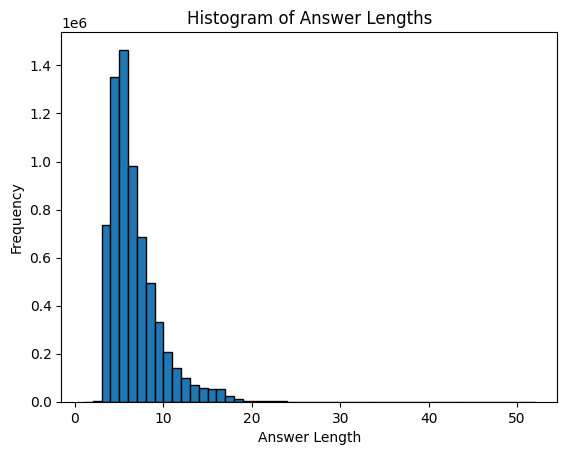

In [7]:
main_df['answer_length'] = main_df['Answer'].apply(lambda x: len(x) if not isinstance(x, float) else len(str(x)))
plt.hist(main_df['answer_length'], bins = range(min(main_df['answer_length']), max(main_df['answer_length']) + 1, 1), edgecolor = 'black')

plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.title('Histogram of Answer Lengths')
plt.show()

In [8]:
# load and preprocess chinese-dataset
chinese_df = pd.read_csv(CHINESE_DATASET)
chinese_df.drop(columns = ['Unnamed: 0'], inplace = True)

# use wordsegmented answers
chinese_df['Segmented Answer'] = chinese_df['answer'].apply(lambda ans: " ".join(segment(ans)) if not isinstance(ans, float) else str(ans))
chinese_df.rename(columns = {'clue': 'Clue', 'answer': 'Answer'}, inplace = True)

chinese_df.head()

,Clue,Answer,Segmented Answer
0,"!, in printing slang",bang,bang
1,"""",dittomark,ditto mark
2,"""",inches,inches
3,"""",quotationmark,quotation mark
4,"""",trauma,trauma


In [9]:
print("Total clue-answer pair in Main-Dataset Version 1: ", len(main_df))
print("Total clue-answer pair in Chinese-Dataset Version 1: ", len(chinese_df))

Total clue-answer pair in Main-Dataset Version 1:  6771776
Total clue-answer pair in Chinese-Dataset Version 1:  396882


In [13]:
# merging the clue-answer paris of main_df (version_1) and chinese dataset (NYT)
clue_answer_df = pd.concat([main_df, chinese_df], axis = 'rows')
clue_answer_df = clue_answer_df.drop_duplicates(subset = ['Clue', 'Answer'])
print("Total unique clue-answer pair count till July 2023: ", len(clue_answer_df))

Total unique clue-answer pair count till July 2023:  7133840


#### Accumulating all the clue-answer pairs from Aug-Dec 2023

In [14]:
all_csv_files = glob.glob(NEW_CSV_SET_DIR + "*.csv")

In [17]:
new_CA_df = pd.DataFrame()

# load and concate all the csv dataframes into a single frame
for csv_file in all_csv_files:
  df = pd.read_csv(csv_file)
  new_CA_df = pd.concat([new_CA_df, df], axis = 'rows')

# drop unwanted columns
new_CA_df.drop(columns = ['Unnamed: 0', 'Date'], inplace = True)
new_CA_df.head()

,Clue,Answer
0,Acting ambassador?,agent
1,100 cents in many European countries,euro
2,'___ a good day for raking leaves!',its
3,"A little squirt, sometimes",oil
4,About to happen,impending


In [19]:
print("Total collected clue-answer pairs from Aug-Dec 2023: ", len(new_CA_df))

Total collected clue-answer pairs from Aug-Dec 2023:  94712


In [21]:
# remove all the duplciates in the 'clue' and 'answer' pairs
new_CA_df = new_CA_df.drop_duplicates(subset = ['Clue', 'Answer'])
print("Total unique collected clue-answer pairs from Aug-Dec 2023 (Before preprocessing): ", len(new_CA_df))

Total unique collected clue-answer pairs from Aug-Dec 2023 (Before preprocessing):  78596


In [22]:
# preprocess newly-added clues
new_CA_df['Clue'] = new_CA_df['Clue'].apply(lambda x: preprocess_clue_fn(x))
new_CA_df['Segmented Answer'] = new_CA_df['Answer'].apply(lambda ans: " ".join(segment(ans)) if not isinstance(ans, float) else str(ans))
new_CA_df = new_CA_df.drop_duplicates(subset = ['Clue', 'Answer', 'Segmented Answer'])

print("Total unique collected clue-answer pairs from Aug-Dec 2023 (After preprocessing): ", len(new_CA_df))
new_CA_df.head()

Total unique collected clue-answer pairs from Aug-Dec 2023 (After preprocessing):  78216


,Clue,Answer,Segmented Answer
0,acting ambassador (wordplay),agent,agent
1,100 cents in many european countries,euro,euro
2,'___ a good day for raking leaves!',its,its
3,"a little squirt, sometimes",oil,oil
4,about to happen,impending,impending


#### Merging newly-collected clue-answer pairs with the main_CA (V_1) and Chinese dataset

In [23]:
print("Previously collected clue-answer pair count: ", len(clue_answer_df))
print("Presently collected clue-answer pair count: ", len(new_CA_df))

Previously collected clue-answer pair count:  7133840
Presently collected clue-answer pair count:  78216


In [24]:
final_CA_dataset_b = pd.concat([clue_answer_df, new_CA_df], axis = 'rows')
print(f"Final clue-answer pair count (before dropping duplicates): {len(final_CA_dataset_b)}")

final_CA_dataset = final_CA_dataset_b.drop_duplicates(subset = ['Clue', 'Answer', 'Segmented Answer'])
print(f"Final clue-answer pair count (after dropping duplicates): {len(final_CA_dataset)}")

print("Reduction in pair-count: ", len(final_CA_dataset_b) - len(final_CA_dataset))

Final clue-answer pair count (before dropping duplicates): 7212056
Final clue-answer pair count (after dropping duplicates): 7168959
Reduction in pair-count:  43097


In [25]:
print("Total additional clue-answer pairs: ", len(final_CA_dataset) - len(clue_answer_df))

Total additional clue-answer pairs:  35119


#### Assessing the answer-types in the clue-answer pairs (Post Processsing)

In [62]:
all_answers = final_CA_dataset['Segmented Answer'].tolist()

In [63]:
invalid_answers = []
for answer in tqdm(all_answers, ncols = 120):
    if isinstance(answer, float):
        answer = str('nan')
    for char in answer:
        if char not in string.ascii_lowercase + ' ':
            invalid_answers.append(answer)
            break

100%|█████████████████████████████████████████████████████████████████████| 7168959/7168959 [00:20<00:00, 352282.89it/s]


In [65]:
print("Number of invalid answers in the 'Segmented Answer': ", len(invalid_answers))

Number of invalid answers in the 'Segmented Answer':  223


**Verdict: Since, the total number of invalid answers are only 223 so, so removal is carried at the moment, all thanks to the word_segment library.**

In [66]:
output_path = "/content/gdrive/MyDrive/Clue-Answer Dataset/Clue-Answer-Dataset_Version_2.csv"

final_CA_dataset.to_csv(output_path)

**Saving new Answer-tsv for updating the answer embedding.**

In [67]:
output_path = "/content/gdrive/MyDrive/First Pass Model/new_answer_list.tsv"
all_answers = final_CA_dataset['Segmented Answer'].drop_duplicates()

ans_id = 0
output_answer_data = []
for answer in tqdm(all_answers, ncols = 120):
  output_answer_data.append(f'{ans_id}\t""""""\t{answer}')
  ans_id += 1

with open(output_path, 'w') as file:
  file.write("\n".join(output_answer_data))

100%|███████████████████████████████████████████████████████████████████████| 469111/469111 [00:00<00:00, 599930.22it/s]
